In [1]:
import requests_cache
import pandas as pd
from retry_requests import retry
import openmeteo_requests 
import os
import datetime

In [9]:
import time

# Load longitude and latitude values from CSV file
csv_path = "locations.csv"  # Update with your actual CSV file path
location_data = pd.read_csv(csv_path)

# creating a data store directory
os.makedirs("data_store", exist_ok=True)

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

#date 2023-11-22
start_date = datetime.date(2023, 5, 1)
end_date = datetime.date(2023, 11, 21)

# Create an empty list to store the results
result_list = []

# Iterate over rows in the DataFrame
for index, row in location_data.iterrows():
    latitude = row['latitude']  # Replace 'latitude_column_name' with the actual column name
    longitude = row['longitude']  # Replace 'longitude_column_name' with the actual column name

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": ["pm10", "pm2_5", "carbon_monoxide", "nitrogen_dioxide", "sulphur_dioxide", "ozone", "dust"],
        "start_date": start_date,
        "end_date": end_date
    }

    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Append latitude, longitude, and elevation to the result_list
    result_list.append({
        "Latitude": response.Latitude(),
        "Longitude": response.Longitude(),
        "Elevation": response.Elevation()
    })

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_pm10 = hourly.Variables(0).ValuesAsNumpy()
    hourly_pm2_5 = hourly.Variables(1).ValuesAsNumpy()
    hourly_carbon_monoxide = hourly.Variables(2).ValuesAsNumpy()
    hourly_nitrogen_dioxide = hourly.Variables(3).ValuesAsNumpy()
    hourly_sulphur_dioxide = hourly.Variables(4).ValuesAsNumpy()
    hourly_ozone = hourly.Variables(5).ValuesAsNumpy()
    hourly_dust = hourly.Variables(6).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s"),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s"),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )}
    hourly_data["pm10"] = hourly_pm10
    hourly_data["pm2_5"] = hourly_pm2_5
    hourly_data["carbon_monoxide"] = hourly_carbon_monoxide
    hourly_data["nitrogen_dioxide"] = hourly_nitrogen_dioxide
    hourly_data["sulphur_dioxide"] = hourly_sulphur_dioxide
    hourly_data["ozone"] = hourly_ozone
    hourly_data["dust"] = hourly_dust
    hourly_data["latitude"] = latitude
    hourly_data["longitude"] = longitude

    hourly_dataframe = pd.DataFrame(data=hourly_data)

    # Save the dataframe to a CSV file in Google Drive
    csv_filename = f"./data_store/hourly_data_{latitude}_{longitude}.csv"
    hourly_dataframe.to_csv(csv_filename, index=False)
    print(f"Data saved to {csv_filename}")

    # adding 5ms delay to avoid rate limiting
    time.sleep(0.50)


Coordinates 32.0°E 72.0°N
Elevation 188.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Data saved to ./data_store/hourly_data_32.03010021_71.8792103.csv
Coordinates 32.400001525878906°E 74.80000305175781°N
Elevation 250.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Data saved to ./data_store/hourly_data_32.36153073_74.69950231.csv
Coordinates 30.400001525878906°E 73.60000610351562°N
Elevation 168.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Data saved to ./data_store/hourly_data_30.25747827_73.67574411.csv
Coordinates 33.20000457763672°E 73.19999694824219°N
Elevation 539.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Data saved to ./data_store/hourly_data_33.27189873_73.18823821.csv
Coordinates 30.400001525878906°E 70.40000915527344°N
Elevation 409.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Data saved to ./data_store/hourly_data_30.39985067_70.43184965.csv
Coordinates 28.800003051757812°E 72.40000915527344°N
Elevat

In [19]:
# creating a function to automate the process

def get_data(start_date, end_date):
    # Load longitude and latitude values from CSV file
    csv_path = "locations.csv"  # Update with your actual CSV file path
    location_data = pd.read_csv(csv_path)

    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Create an empty list to store the results
    result_list = []

    # Iterate over rows in the DataFrame
    for index, row in location_data.iterrows():
        latitude = row['latitude']  # Replace 'latitude_column_name' with the actual column name
        longitude = row['longitude']  # Replace 'longitude_column_name' with the actual column name

        # Make sure all required weather variables are listed here
        # The order of variables in hourly or daily is important to assign them correctly below
        url = "https://air-quality-api.open-meteo.com/v1/air-quality"
        params = {
            "latitude": latitude,
            "longitude": longitude,
            "hourly": ["pm10", "pm2_5", "carbon_monoxide", "nitrogen_dioxide", "sulphur_dioxide", "ozone", "dust"],
            "start_date": start_date,
            "end_date": end_date
        }

        responses = openmeteo.weather_api(url, params=params)

        # Process first location. Add a for-loop for multiple locations or weather models
        response = responses[0]
        print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
        print(f"Elevation {response.Elevation()} m asl")
        print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
        print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

        # Append latitude, longitude, and elevation to the result_list
        result_list.append({
            "Latitude": response.Latitude(),
            "Longitude": response.Longitude(),
            "Elevation": response.Elevation()
        })

        # Process hourly data. The order of variables needs to be the same as requested.
        hourly = response.Hourly()
        hourly_pm10 = hourly.Variables(0).ValuesAsNumpy()
        hourly_pm2_5 = hourly.Variables(1).ValuesAsNumpy()
        hourly_carbon_monoxide = hourly.Variables(2).ValuesAsNumpy()
        hourly_nitrogen_dioxide = hourly.Variables(3).ValuesAsNumpy()
        hourly_sulphur_dioxide = hourly.Variables(4).ValuesAsNumpy()
        hourly_ozone = hourly.Variables(5).ValuesAsNumpy()
        hourly_dust = hourly.Variables(6).ValuesAsNumpy()

        hourly_data = {"date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s"),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s"),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )}
        hourly_data["pm10"] = hourly_pm10
        hourly_data["pm2_5"] = hourly_pm2_5
        hourly_data["carbon_monoxide"] = hourly_carbon_monoxide
        hourly_data["nitrogen_dioxide"] = hourly_nitrogen_dioxide
        hourly_data["sulphur_dioxide"] = hourly_sulphur_dioxide
        hourly_data["ozone"] = hourly_ozone
        hourly_data["dust"] = hourly_dust
        hourly_data["latitude"] = latitude
        hourly_data["longitude"] = longitude



        hourly_dataframe = pd.DataFrame(data=hourly_data)

        # Save the dataframe to a CSV file in Google Drive
        csv_filename = f"./data_store/hourly_data_{latitude}_{longitude}.csv"
        hourly_dataframe.to_csv(csv_filename, index=False)
        print(f"Data saved to {csv_filename}")

            

In [5]:
# This code is supposed to run automatically every week. creating a function to automate the process
# creating a json file to store the last date the data was collected, anf then the next date to collect data which is the next seven days
# the code will check the json file to know the last date the data was collected, and then collect data for the next seven days
# the code will then update the json file with the new date, and then the process continues
# the code will run every week to collect data for the next seven days

import json
import datetime
import os

last_date = datetime.date(2024, 5, 25)
next_date = last_date + datetime.timedelta(days=7)

data = {
    "last_date": str(last_date),
    "next_date": str(next_date)
}

with open("date.json", "w") as file:
    json.dump(data, file)

with open("date.json", "r") as file:
    data = json.load(file)
    last_date = data["last_date"]
    next_date = data["next_date"]

In [6]:
next_date

'2024-06-01'

In [14]:
from datetime import datetime
date_string = "2024-05-27"
date_obj = datetime.strptime(date_string, "%Y-%m-%d").date()
print(date_obj)
print(type(date_obj))


2024-05-27
<class 'datetime.date'>


In [17]:
import datetime

dt = datetime.date(2024, 5, 1)
print(type(dt))

<class 'datetime.date'>


In [20]:
start_date = datetime.date(2024, 5, 1)
end_date = datetime.date(2024, 5, 25)
get_data(start_date, end_date)

Coordinates 32.0°E 72.0°N
Elevation 188.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Data saved to ./data_store/hourly_data_32.03010021_71.8792103.csv
Coordinates 32.400001525878906°E 74.80000305175781°N
Elevation 250.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Data saved to ./data_store/hourly_data_32.36153073_74.69950231.csv
Coordinates 30.400001525878906°E 73.60000610351562°N
Elevation 168.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Data saved to ./data_store/hourly_data_30.25747827_73.67574411.csv
Coordinates 33.20000457763672°E 73.19999694824219°N
Elevation 539.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Data saved to ./data_store/hourly_data_33.27189873_73.18823821.csv
Coordinates 30.400001525878906°E 70.40000915527344°N
Elevation 409.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Data saved to ./data_store/hourly_data_30.39985067_70.43184965.csv
Coordinates 28.800003051757812°E 72.40000915527344°N
Elevat

## Preparing the dataset

In [10]:
# reading files in the data_store folder

data_folder = "./data_store"
data_files = os.listdir(data_folder)

# data_loading function

def data_loader(data_folder):
    data = []
    for file in data_files:
        file_path = os.path.join(data_folder, file)
        df = pd.read_csv(file_path)
        data.append(df)

    # merging the data into a single dataframe
    final_data = pd.concat(data, axis=0)

    # merging the data with location data
    location_data = pd.read_csv("locations.csv")
    final_data_1 = pd.merge(final_data, location_data, on=["latitude", "longitude"], how="left")
    final_data_1["id"] = final_data_1["id"].astype(float)

    # dropping the latitude and longitude columns
    final_data_2 = final_data_1.drop(["latitude", "longitude"], axis=1)

    # renaming id as location_id
    final_data_2.rename(columns={"id": "location_id"}, inplace=True)

    # converting the date column to datetime
    final_data_2["date"] = pd.to_datetime(final_data_2["date"])

    # setting date as the index
    final_data_3 = final_data_2.set_index("date")

    # loading district dataset
    district = pd.read_csv('Join.csv')
    # rename id as location_id
    district = district.rename(columns={'id': 'location_id'})
    # selecting only location_id and district
    district = district[['location_id', 'district']]

    index = final_data_3.index

    # converting location_id to string
    final_data_3['location_id'] = final_data_3['location_id'].astype(float)
    district['location_id'] = district['location_id'].astype(float)

    # merging forecasted data with district data  based on location_id
    final_data_3 = final_data_3.merge(district, on='location_id', how='left') 

    # calculating AQI
    # final_data_3['AQI'] = final_data_3['pm2_5'] * 0.25 + final_data_3['pm10'] * 0.25 + final_data_3['nitrogen_dioxide'] * 0.15 + final_data_3['sulphur_dioxide'] * 0.1 + final_data_3['carbon_monoxide'] * 0.1 + final_data_3['ozone'] * 0.1 + final_data_3['dust'] * 0.05

    final_data_3['date'] = index

    # rewriting the column names in Alphabetical order
    final_data_3 = final_data_3.reindex(sorted(final_data_3.columns), axis=1)
    # making sure that the pollutant names start with capital letters
    final_data_3.columns = final_data_3.columns.str.capitalize()
    
    # # creating a date column
    # final_data_3['date'] = final_data_3.index
    
    # # Extract date only (without time)
    # final_data_3['date_only'] = final_data_3['date'].dt.date


    # # Group by date and district, then get the maximum AQI for each group
    # daily_max_aqi = final_data_3.groupby(['date_only', 'District'])['Aqi'].max().reset_index()

    # # Rename columns for clarity
    # daily_max_aqi.columns = ['Date', 'District', 'Max_Aqi']
    # daily_max_aqi
    
    return final_data_3.reset_index(drop=True)

data = data_loader(data_folder)


In [11]:
data

,Carbon_monoxide,Date,District,Dust,Location_id,Nitrogen_dioxide,Ozone,Pm10,Pm2_5,Sulphur_dioxide
0,142.0,2023-05-01 00:00:00,Bahawalpur,8.0,39.0,1.4,54.0,22.3,13.2,1.0
1,143.0,2023-05-01 01:00:00,Bahawalpur,10.0,39.0,1.3,57.0,22.6,13.6,1.0
2,145.0,2023-05-01 02:00:00,Bahawalpur,12.0,39.0,1.3,61.0,23.2,13.6,0.9
3,145.0,2023-05-01 03:00:00,Bahawalpur,15.0,39.0,1.1,69.0,25.4,13.6,0.9
4,143.0,2023-05-01 04:00:00,Bahawalpur,18.0,39.0,0.9,79.0,28.8,14.4,1.0
...,...,...,...,...,...,...,...,...,...,...
1475995,815.0,2023-11-21 19:00:00,Attock,1.0,233.0,38.8,32.0,29.7,20.5,7.0
1475996,699.0,2023-11-21 20:00:00,Attock,1.0,233.0,28.6,35.0,24.2,16.6,5.9
1475997,606.0,2023-11-21 21:00:00,Attock,1.0,233.0,20.5,35.0,19.0,13.0,4.8
1475998,528.0,2023-11-21 22:00:00,Attock,1.0,233.0,15.4,31.0,14.3,9.7,3.7


In [12]:
# saving as new_data.csv in the Old_data folder
data.to_csv("Old_data/older_data.csv", index=False)

In [31]:
# creating a function that takes in a date and district name, then return the max aqi for the last 30 days
# another one should collect for the last 14 days

import pandas as pd
from datetime import timedelta
from io import StringIO
import matplotlib.pyplot as plt


daily_max_aqi = data
def get_max_aqi_last_days(date, district, days):
    # Convert the input date to a datetime object
    end_date = pd.to_datetime(date).date()
    start_date = end_date - timedelta(days=days)
    
    # Filter the data for the given district and date range
    filtered_data = daily_max_aqi[(daily_max_aqi['District'] == district) & 
                                  (daily_max_aqi['Date'] >= start_date) & 
                                  (daily_max_aqi['Date'] <= end_date)]
    
    if filtered_data.empty:
        return None
    
    # Get the maximum AQI over the specified period
    max_aqi = filtered_data
    
    return max_aqi

def get_max_aqi_last_30_days(date, district):
    return get_max_aqi_last_days(date, district, 30)

def get_max_aqi_last_14_days(date, district):
    return get_max_aqi_last_days(date, district, 14)

# Example usage
date = '2024-06-14'
district = 'Attock'

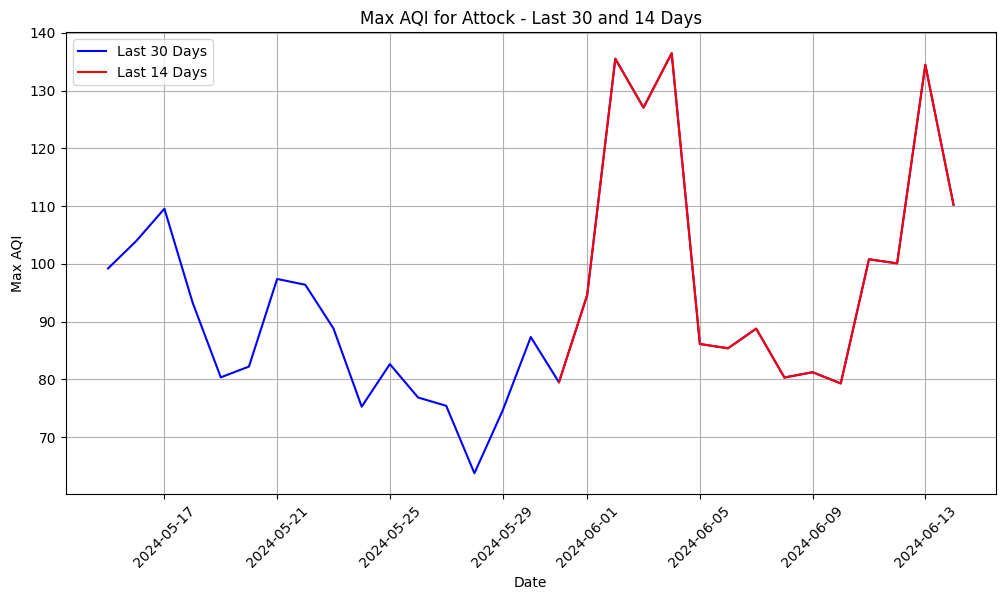

In [34]:
data_30_days = get_max_aqi_last_days(date, district, 30)
data_14_days = get_max_aqi_last_days(date, district, 14)

# Plotting the data
plt.figure(figsize=(12, 6))

# Plot the last 30 days data
plt.plot(data_30_days['Date'], data_30_days['Max_Aqi'], label='Last 30 Days', color='blue')

# Plot the last 14 days data
plt.plot(data_14_days['Date'], data_14_days['Max_Aqi'], label='Last 14 Days', color='red')

# Adding titles and labels
plt.title(f'Max AQI for {district} - Last 30 and 14 Days')
plt.xlabel('Date')
plt.ylabel('Max AQI')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.show()

In [24]:
# saving as historical data
data.to_csv("historical_data.csv", index=False)

## Extras

In [18]:
# saving the forecasted data
data.to_csv('last_year_pollutant.csv', index=True)

In [19]:
def last_year_aggregate_pollutants(initial_time, district):
    forecasted_df = pd.read_csv('../New_data/last_year_pollutant.csv')
    # replacing unnamed column with date
    forecasted_df = forecasted_df.rename(columns={'Unnamed: 0': 'date'})
    # setting the date column as index
    forecasted_df = forecasted_df.set_index('date')
    # converting the index to datetime
    forecasted_df.index = pd.to_datetime(forecasted_df.index)
    # Parse the initial time
    initial_time = pd.to_datetime(initial_time)
    # converting initial time to last year
    initial_time = initial_time - pd.Timedelta(days=366)
    final_time = initial_time + pd.Timedelta(days=14)

    # Filter the DataFrame for the specified district and time range
    filtered_df = forecasted_df[(forecasted_df.index >= initial_time) & (forecasted_df.index <= final_time) & (forecasted_df['District'] == district)]

    # Select only numeric columns for aggregation
    numeric_columns = filtered_df.select_dtypes(include=['float64', 'int64']).columns

    # Group by hour and aggregate pollutants
    aggregated_df = filtered_df[numeric_columns].resample('H').mean()
    
    return aggregated_df.drop(columns=['Location_id'])

from datetime import datetime
from pytz import timezone
def get_pakistan_time():
    # getting the current date and time in Pakistan
    now = datetime.now(timezone('Asia/Karachi'))
    # returning it in this format '2021-09-01 00:00:00'
    formatted_time = now.strftime('%Y-%m-%d %H:00:00')
    return formatted_time


time = get_pakistan_time()
last_year_df = last_year_aggregate_pollutants(time, 'Lahore')

C:\Users\timmy\AppData\Local\Temp\ipykernel_21780\3677010545.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aggregated_df = filtered_df[numeric_columns].resample('H').mean()


In [20]:
last_year_df

,Aqi,Carbon_monoxide,Dust,Nitrogen_dioxide,Ozone,Pm10,Pm2_5,Sulphur_dioxide
date,,,,,,,,
2023-06-03 12:00:00,74.020000,342.000000,7.333333,10.733333,187.333333,42.933333,28.266667,13.100000
2023-06-03 13:00:00,119.520000,763.666667,7.333333,34.966667,153.000000,49.100000,32.866667,17.500000
2023-06-03 14:00:00,190.658333,1366.666667,6.333333,69.400000,104.000000,72.633333,49.333333,23.733333
2023-06-03 15:00:00,276.738333,2119.333333,6.333333,105.833333,50.000000,95.866667,65.600000,32.466667
2023-06-03 16:00:00,328.590000,2551.333333,6.333333,115.600000,32.333333,115.466667,79.200000,39.000000
...,...,...,...,...,...,...,...,...
2023-06-17 08:00:00,76.516667,293.000000,21.666667,4.366667,185.333333,62.433333,37.933333,18.533333
2023-06-17 09:00:00,79.288333,308.666667,19.666667,5.733333,191.666667,63.033333,38.733333,19.700000
2023-06-17 10:00:00,76.281667,274.000000,18.666667,4.133333,198.000000,63.233333,39.200000,19.200000


In [21]:
def aggregate_pollutants(initial_time, district):
    forecasted_df = pd.read_csv('../New_data/forecasted_pollutant.csv')
    # replacing unnamed column with date
    forecasted_df = forecasted_df.rename(columns={'Unnamed: 0': 'date'})
    # setting the date column as index
    forecasted_df = forecasted_df.set_index('date')
    # converting the index to datetime
    forecasted_df.index = pd.to_datetime(forecasted_df.index)
    # Parse the initial time
    initial_time = pd.to_datetime(initial_time)
    final_time = initial_time + pd.Timedelta(days=14)

    # Filter the DataFrame for the specified district and time range
    filtered_df = forecasted_df[(forecasted_df.index >= initial_time) & (forecasted_df.index <= final_time) & (forecasted_df['District'] == district)]

    # Select only numeric columns for aggregation
    numeric_columns = filtered_df.select_dtypes(include=['float64', 'int64']).columns

    # Group by hour and aggregate pollutants
    aggregated_df = filtered_df[numeric_columns].resample('H').mean()
    
    return aggregated_df.drop(columns=['Location_id'])


time = get_pakistan_time()
forecasted_df = aggregate_pollutants(time, 'Lahore')

C:\Users\timmy\AppData\Local\Temp\ipykernel_21780\1778448340.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aggregated_df = filtered_df[numeric_columns].resample('H').mean()


In [22]:
forecasted_df

,Aqi,Carbon_monoxide,Dust,Nitrogen_dioxide,Ozone,Pm_10,Pm_25,Sulphur_dioxide
date,,,,,,,,
2024-06-03 12:00:00,71.807788,255.244350,171.978323,10.017753,133.738320,55.258966,33.262736,6.775147
2024-06-03 13:00:00,72.237787,259.519463,174.832640,17.454190,121.196050,55.253588,33.262342,6.774920
2024-06-03 14:00:00,72.790423,266.576537,173.255711,28.983137,103.187800,55.243328,33.261668,6.774857
2024-06-03 15:00:00,72.309993,274.803780,175.967700,34.567143,80.447915,55.234169,33.261437,6.774666
2024-06-03 16:00:00,71.914137,285.910237,174.730380,35.363059,64.832162,55.224811,33.261016,6.774614
...,...,...,...,...,...,...,...,...
2024-06-17 08:00:00,78.330493,208.460160,217.827330,34.618597,186.017143,55.224976,33.260110,6.773364
2024-06-17 09:00:00,77.445670,210.988660,217.827253,32.515656,177.794827,55.224976,33.260108,6.773364
2024-06-17 10:00:00,76.664588,213.742858,217.827163,30.987935,169.521433,55.224976,33.260111,6.773364


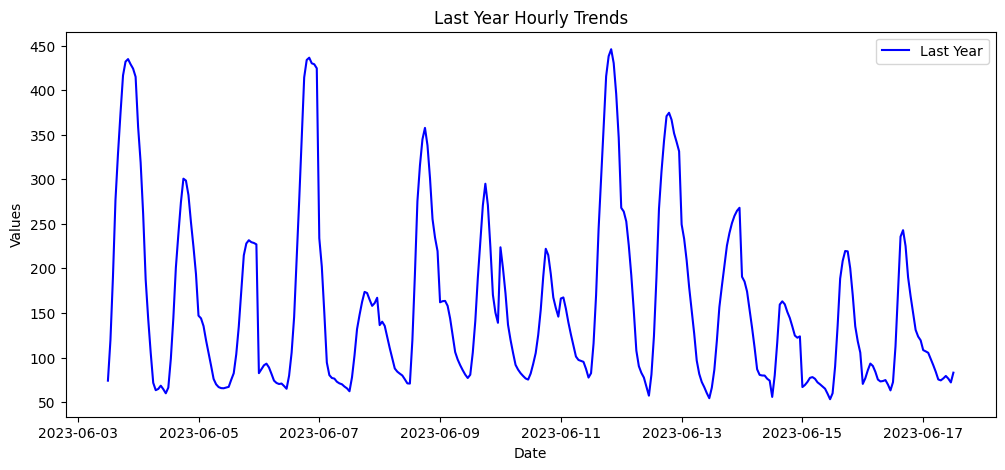

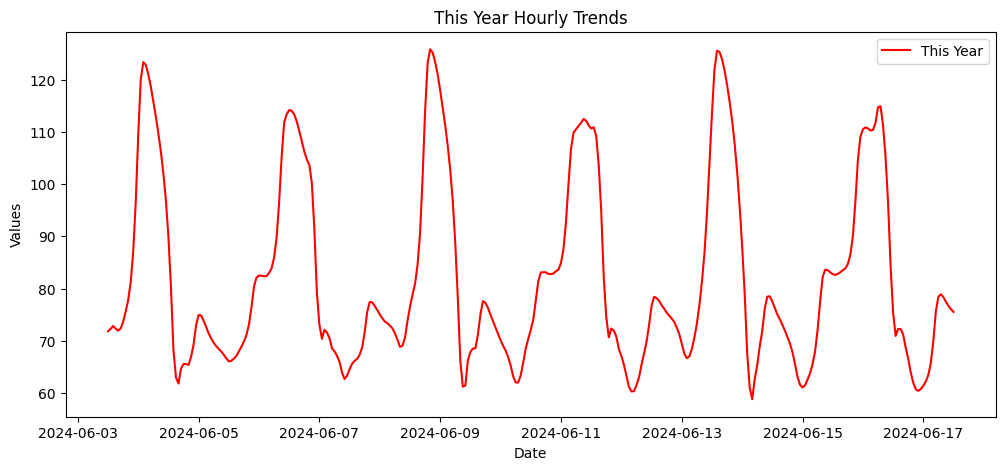

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_separate(df1, df2, y1_column, y2_column, title1="Last Year Hourly Trends", title2="This Year Hourly Trends", y1_label="Last Year", y2_label="This Year"):
    # Ensure the index is a datetime type for proper plotting
    if not pd.api.types.is_datetime64_any_dtype(df1.index):
        raise ValueError("The index of df1 must be a datetime type")
    if not pd.api.types.is_datetime64_any_dtype(df2.index):
        raise ValueError("The index of df2 must be a datetime type")

    # Plot for last year
    plt.figure(figsize=(12, 5))
    plt.plot(df1.index, df1[y1_column], label=y1_label, color='b')
    plt.title(title1)
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    # Plot for this year
    plt.figure(figsize=(12, 5))
    plt.plot(df2.index, df2[y2_column], label=y2_label, color='r')
    plt.title(title2)
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

plot_separate(last_year_df, forecasted_df, 'Aqi', 'Aqi')


## Export for pollutants for finetuning

In [8]:
# exporting the final data to a csv file for each pollutant

pm_10 = final_data_2.pivot_table(index="date", columns="location_id", values="pm10")
pm_10.to_csv("update_pm_10.csv")

pm_2_5 = final_data_2.pivot_table(index="date", columns="location_id", values="pm2_5")
pm_2_5.to_csv("update_pm_25.csv")

carbon_monoxide = final_data_2.pivot_table(index="date", columns="location_id", values="carbon_monoxide")
carbon_monoxide.to_csv("update_carbon_monoxide.csv")

nitrogen_dioxide = final_data_2.pivot_table(index="date", columns="location_id", values="nitrogen_dioxide")
nitrogen_dioxide.to_csv("update_nitrogen_dioxide.csv")

sulphur_dioxide = final_data_2.pivot_table(index="date", columns="location_id", values="sulphur_dioxide")
sulphur_dioxide.to_csv("update_sulphur_dioxide.csv")

ozone = final_data_2.pivot_table(index="date", columns="location_id", values="ozone")
ozone.to_csv("update_ozone.csv")

dust = final_data_2.pivot_table(index="date", columns="location_id", values="dust")
dust.to_csv("update_dust.csv")

## Historical Data